In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-11-01 14:53:24.907432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 14:53:24.907463: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 14:53:24.907498: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 14:53:24.915315: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


這段程式碼的作用是配置 TensorFlow 在使用 GPU 時的一些設置。它執行以下操作：

1. `tf.config.experimental.list_physical_devices('GPU')`：此行程式碼用於獲取系統上可用的物理 GPU 裝置清單，並將其存儲在 `gpus` 變數中。

2. 條件檢查 `if gpus:`：這個條件檢查確保至少有一個 GPU 裝置可用。

3. 嘗試設置 GPU 配置：下面的 `try` 塊中的程式碼用於配置 TensorFlow 的 GPU 使用方式。

   - `tf.config.experimental.set_visible_devices(gpus[0], 'GPU')`：這一行將指定 TensorFlow 只使用第一個 GPU，即將 TensorFlow 限制在第一個 GPU 上運行。

   - `for gpu in gpus:` 迴圈：這個迴圈用於遍歷所有可用的 GPU 裝置，並設置它們的內存增長選項為 True。`set_memory_growth` 函數將 GPU 內存設置為動態增長，以避免在啟動 TensorFlow 時分配全部 GPU 內存，從而更有效地使用 GPU 內存。

4. `logical_gpus = tf.config.experimental.list_logical_devices('GPU')`：此行程式碼用於獲取邏輯 GPU 裝置的清單，並將其存儲在 `logical_gpus` 變數中。

5. `print(len(gpus), "個物理 GPU,", len(logical_gpus), "個邏輯 GPU")`：最後，它會列印出物理 GPU 和邏輯 GPU 的數量。

如果成功配置了 GPU 選項，它會告訴您有多少個物理 GPU 和邏輯 GPU 可用。如果在配置 GPU 選項時發生錯誤，它會捕獲 `RuntimeError` 並列印相應的錯誤消息。

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


2023-11-01 14:53:26.361260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 14:53:26.361365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-01 14:53:26.364515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Load dataset via tf.keras.dataset
Currently, tf.keras.dataset supports 7 datasets. Including:

- `mnist` module: MNIST handwritten digits dataset.
- `cifar10` module: CIFAR10 small images classification dataset.
- `cifar100` module: CIFAR100 small images classification dataset.
- `fashion_mnist` module: Fashion-MNIST dataset.
- `imdb` module: IMDB sentiment classification dataset.
- `boston_housing` module: Boston housing price regression dataset.
- `reuters` module: Reuters topic classification dataset.

目前，`tf.keras.dataset` 支援七個數據集，包括：

1. `mnist` 模組：MNIST手寫數字數據集。
2. `cifar10` 模組：CIFAR10小圖像分類數據集。
3. `cifar100` 模組：CIFAR100小圖像分類數據集。
4. `fashion_mnist` 模組：Fashion-MNIST 數據集。
5. `imdb` 模組：IMDB情感分類數據集。
6. `boston_housing` 模組：波士頓房價回歸數據集。
7. `reuters` 模組：Reuters主題分類數據集。

In this lab, we will use MNIST dataset to demo how to build a neural network. MNIST contains 70,000 images of hand-written digits, 60,000 for training while 10,000 for testing, each $28×28$ pixels, in greyscale with pixel-values from 0 to 255.

In [3]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Load and prepare the MNIST dataset. Convert the samples from integers to floating-point numbers:

In [4]:
# 透過tf.keras.datasets.mnist導入了MNIST資料集的模組
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 資料預處理：在最後兩行，對影像資料進行了預處理。 將像素值從0到255的範圍縮放到0到1之間，這是一種常見的資料標準化
# 方法，有助於神經網路的訓練。 這是因為神經網路通常更容易處理值在0到1之間的輸入資料
x_train, x_test = x_train / 255.0, x_test / 255.0

Training data: (60000, 28, 28)
Test data: (10000, 28, 28)


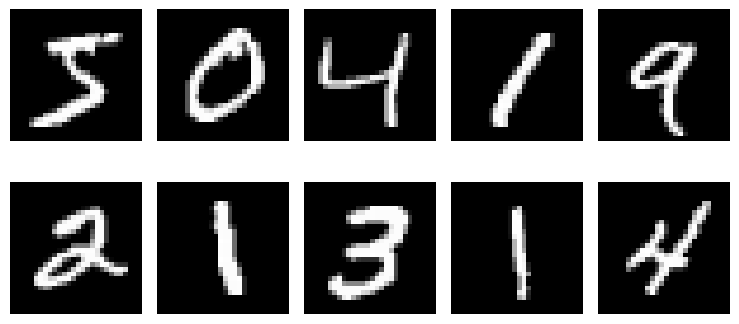

In [5]:
print("Training data: {}".format(x_train.shape))
print("Test data: {}".format(x_test.shape))
show_images(x_train)

### Build model via Sequential API

#### When to use?
A Sequential API is the simplest way to build a model, which is appropriate for **a plain stack of layers** where each layer has **exactly one input tensor and one output tensor.**

Build the tf.keras.Sequential model by stacking layers. Choose an optimizer and loss function for training:

`Sequential` API 是 TensorFlow 中最簡單的建立模型的方式，適用於那些**具有一系列層、每個層只有一個輸入張量和一個輸出張量**的簡單堆疊結構。

使用 `Sequential` API 的情況包括：

1. **前饋神經網絡（Feedforward Neural Networks）：** 當您需要構建一個簡單的前饋神經網絡時，`Sequential` API 是一個很好的選擇。前饋神經網絡由一系列全連接層構成，每一層都將輸入傳遞到輸出，沒有跳躍連接或複雜的拓撲結構。

2. **卷積神經網絡（Convolutional Neural Networks）：** 對於圖像分類等任務，卷積神經網絡是常用的模型類型。`Sequential` API 可以用於簡化卷積神經網絡的構建，通過將卷積層、池化層和全連接層等層堆疊在一起。

3. **順序層疊結構：** 當您的模型結構是一系列層的簡單線性堆疊，沒有分支或合併時，`Sequential` API 是最直接的選擇。

以下是使用 `Sequential` API 構建模型的一般步驟：

1. 創建一個 `Sequential` 模型對象。
2. 通過 `add()` 方法按順序添加各個層，每個層定義了輸入形狀和激活函數等。
3. 配置優化器（如梯度下降法）和損失函數，以便進行模型的編譯。
4. 使用 `fit()` 方法進行模型的訓練。

這種方式非常適合構建相對簡單的神經網絡，但如果需要構建複雜的模型，包括多個輸入或輸出，或者有分支結構，可能需要使用函數式 API 來更靈活地定義模型結構。

---

這段程式碼使用 `Sequential` API 創建了一個神經網路模型。以下是對該模型的說明：

這個模型是一個簡單的前饋神經網路，包含以下層：

1. `Flatten` 層：這是輸入層，用於將輸入的二維圖像數據（28x28像素）展平為一維向量。這是因為神經網路的第一層通常需要接受一維數據。

2. `Dense` 層（全連接層）：這是第一個隱藏層，包含128個神經元。它使用 ReLU（Rectified Linear Unit）激活函數，這是一個常用的非線性激活函數。

3. `Dropout` 層：這是一種正規化技術，用於在訓練過程中隨機地丟棄一部分神經元，以減少過擬合風險。這裡的丟棄率為0.2，表示每個神經元在訓練中以20%的概率被丟棄。

4. `Dense` 層：這是輸出層，包含10個神經元，對應於資料集中的10個類別。這一層沒有指定激活函數，因此通常在這裡使用原始輸出值，然後應用 softmax 激活函數來獲得類別概率分佈。

這個模型適用於圖像分類任務，其中輸入是28x28像素的圖像，輸出是屬於10個不同類別的概率分佈。通常，您需要通過編譯模型來選擇優化器和損失函數，然後使用 `fit()` 方法來進行訓練。

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

For each example the model returns a vector of "logits" or "log-odds" scores, one for each class.

In [7]:
# 這個model還沒有train過，因此機率會是隨機的(/10)
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.0741871 ,  0.19985753,  0.46555752,  0.07981288,  0.35039562,
         0.00945687, -0.20284194, -0.26526338, -0.44500738, -0.6815462 ]],
      dtype=float32)

In [8]:
tf.nn.softmax(predictions).numpy()

array([[0.1062828 , 0.12051497, 0.15719293, 0.10688242, 0.14009379,
        0.09962104, 0.08056582, 0.07569054, 0.06323823, 0.04991742]],
      dtype=float32)

Note: It is possible to bake this tf.nn.softmax in as the activation function for the **last layer of the network**. While this can make the model **output more directly interpretable**, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output.

The **losses.SparseCategoricalCrossentropy** loss takes a vector of logits and a True index and returns a scalar loss for each example.

這段註釋提到了關於神經網路輸出層的激活函數以及損失函數的選擇。 Softmax作為輸出層激活函數： 通常，可以將Softmax函數用作神經網路的輸出層激活函數，特別是在多類別分類問題中。 Softmax函數將神經網路的原始輸出轉換為類別機率分佈，使輸出更容易解釋。 每個輸出神經元對應於一個類別，並輸出表示屬於每個類別的機率。 這樣的產出對於多類別分類問題非常有用。 損失函數選擇： 在這種情況下，可以使用 losses.SparseCategoricalCrossentropy 作為損失函數。 這個損失函數接受模型的原始輸出（也稱為 logits）和真實類別索引，然後計算每個樣本的損失。 它對於多類別分類問題非常適用，因為它可以處理類別之間的關係，並傳回一個標量損失值。 雖然可以將Softmax作為輸出層激活函數，但註釋中提到，這種做法不被鼓勵，因為在某些情況下，使用Softmax輸出可能會導致數值穩定性問題。 相反，將Softmax操作包含在損失函數中通常更為穩定，因為這允許進行數值穩定的計算。 總之，選擇適當的輸出層激活函數和損失函數取決於特定的問題和模型結構，但在多類別分類問題中，Softmax和SparseCategoricalCrossentropy通常是常用的選擇。

In [9]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the true class: It is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.log(1/10) ~= 2.3`.

這段文字解釋了損失函數 SparseCategoricalCrossentropy 的工作原理以及在未經過訓練的模型上的期望行為。

SparseCategoricalCrossentropy 損失是真實類別的負對數機率。 這意味著它測量了模型對正確類別的不確定性。 當模型對正確類別非常確定時，損失接近零。 這是因為 -tf.log(1/10) 是當模型對每個類別的機率都相等時的預期損失，即模型對正確類別的機率為1/10。

在這段文字中，提到**未經訓練的模型給出的類別機率接近隨機（每個類別機率為1/10）**，因此初始損失應該接近 -tf.log(1/10)，即大約2.3。 這是因為未經過訓練的模型在分類問題中幾乎是隨機的，對正確類別的預測機率接近隨機猜測。

這個資訊對於理解損失函數的工作方式以及初步評估模型的表現非常有幫助。 在訓練過程中，損失函數的目標是逐漸減小，以便模型能提高正確類別的預測機率，從而減少損失值。

In [10]:
loss_fn(y_train[:1], predictions).numpy()

2.306382

In [11]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

The Model.summary method prints a string summary of the network, which is quite useful to examining model architecture before training.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The `Model.fit` method adjusts the model parameters to minimize the loss:

In [13]:
model.fit(x_train, y_train, batch_size=32, epochs=5)

Epoch 1/5


2023-11-01 14:53:28.957205: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7f4c0fc010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-01 14:53:28.957220: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-11-01 14:53:28.960361: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-01 14:53:28.976906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-01 14:53:29.044231: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 3s 1ms/step - loss: 0.2961 - accuracy: 0.9131
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1434 - accuracy: 0.9566
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1089 - accuracy: 0.9667
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0883 - accuracy: 0.9724
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0744 - accuracy: 0.9760


The Model.evaluate method checks the models performance, usually on a "Validation-set" or "Test-set".

In [14]:
model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.0742 - accuracy: 0.9769 - 292ms/epoch - 932us/step


[0.07415842264890671, 0.9768999814987183]

The image classifier is now trained to ~98% accuracy on this dataset.

In [15]:
# Destroys the current TF graph and creates a new one.
tf.keras.backend.clear_session()

`tf.keras.backend.clear_session()` 是 TensorFlow 中用于清除当前会话资源的函数。通常在需要释放内存资源或重新构建神经网络模型时使用。该函数会执行以下操作：

1. 清除当前会话中的计算图。
2. 关闭当前会话，释放与该会话相关的资源。
3. 重置全局图（global graph）和默认图（default graph）。

通常情况下，您会在以下情况下使用这个函数：

- 当您需要重新构建或调整神经网络模型时，可以在重新创建模型之前清除会话以释放之前的资源。
- 当您在一个脚本中多次构建和训练模型时，可以在每次训练之前清除会话，以避免内存泄漏或资源冲突问题。

需要注意的是，某些情况下，特别是在使用 TensorFlow 2.x 版本的情况下，不需要显式调用 `tf.keras.backend.clear_session()`，因为 TensorFlow 2.x 使用了即刻执行（eager execution）模式，资源管理更加自动化。但在某些特定情况下，显式调用此函数仍然是有用的。

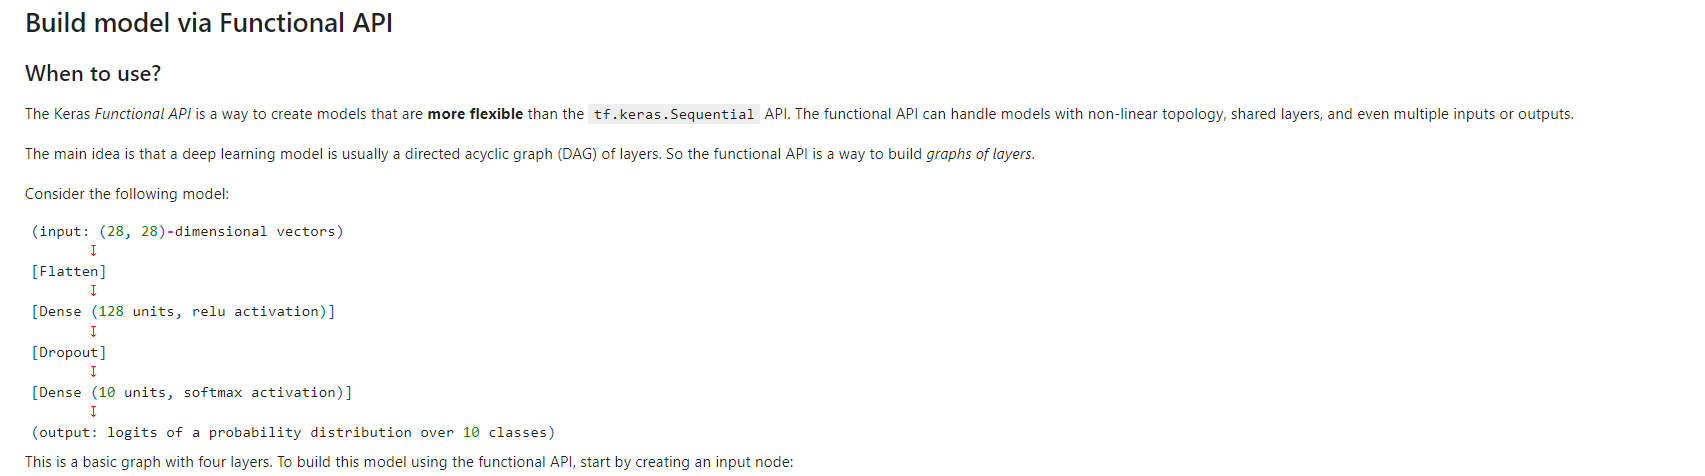

Keras 功能 API 是一種創建比 tf.keras.Sequential API 更靈活的模型的方式。 功能 API 可以處理具有非線性拓撲、共享層甚至多個輸入或輸出的模型。 其主要思想是，深度學習模型通常是一組層構成的有向無環圖（DAG）。 因此，功能 API 是一種建立層圖的方式。

In [16]:
inputs = tf.keras.Input(shape=(28, 28))

The shape of the data is set as a 784-dimensional vector. The batch size is always omitted since only the shape of each sample is specified. The inputs that is returned contains information about the shape and dtype of the input data that you feed to your model.

資料的形狀被設定為784維向量。 由於僅指定了每個樣本的形狀，因此始終省略批量大小。 傳回的輸入包含有關您提供給模型的輸入資料的形狀和資料類型的資訊。

In [17]:
print("Shape:", inputs.shape)
print("dtype:", inputs.dtype)

Shape: (None, 28, 28)
dtype: <dtype: 'float32'>


You create a new node in the graph of layers by calling a layer on this inputs object. The "layer call" action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get x as the output.

您可以透過呼叫此輸入物件上的圖層來在圖層圖中建立一個新節點。 「圖層呼叫」操作就像從「輸入」到您建立的該圖層繪製一個箭頭。 您將輸入“傳遞”到密集層，然後得到 x 作為輸出。

Let's add a few more layers to the graph of layers:

In [18]:
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(10)(x)


At this point, you can create a Model by specifying its inputs and outputs in the graph of layers:

In [19]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training, evaluation, and inference work exactly in the same way for models built using the functional API as for Sequential models.

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/5
750/750 [==============================] - 2s 2ms/step - loss: 0.3772 - accuracy: 0.8918 - val_loss: 0.1877 - val_accuracy: 0.9454
Epoch 2/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1838 - accuracy: 0.9460 - val_loss: 0.1338 - val_accuracy: 0.9606
Epoch 3/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1382 - accuracy: 0.9598 - val_loss: 0.1112 - val_accuracy: 0.9677
Epoch 4/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1125 - accuracy: 0.9659 - val_loss: 0.1020 - val_accuracy: 0.9705
Epoch 5/5
750/750 [==============================] - 1s 1ms/step - loss: 0.0940 - accuracy: 0.9710 - val_loss: 0.0909 - val_accuracy: 0.9732
313/313 - 0s - loss: 0.0882 - accuracy: 0.9717 - 220ms/epoch - 704us/step
Test loss: 0.08823101967573166
Test accuracy: 0.9717000126838684


In [21]:
# Destroys the current TF graph and creates a new one.
tf.keras.backend.clear_session()

### Build model via Model Subclassing
#### When to use?

The final method to implement a model architecture is called Model Subclassing. Model subclassing is **fully-customizable** and enables you to **implement your own custom forward-pass of the model**. However, this flexibility and customization comes at a cost — model subclassing is way harder to utilize than the Sequential API or Functional API.

So, if the model subclassing method is so hard to use, why bother utilizing it all?

Exotic architectures or custom layer/model implementations, **especially those utilized by researchers**, can be extremely challenging, if not impossible, to implement using the standard Sequential or Functional APIs. Instead, researchers wish to have control over every nuance of the network and training process — and that’s exactly what model subclassing provides them.

Use tf.data to batch and shuffle the dataset:

透過模型子類化建立模型是一種完全可自訂的方法，它允許您實現自己的模型前向傳遞邏輯。 然而，這種靈活性和自訂性是有代價的 — 模型子類化相對於 Sequential API 或 Functional API 更難使用。

那麼，如果模型子類化方法如此難以使用，為什麼還要使用它呢？

對於某些異類架構或自訂層/模型實現，尤其是研究中使用的那些，使用標準的 Sequential 或 Functional API 可能會非常具有挑戰性，甚至不可能實現。 相反，研究人員希望能夠控製網路和訓練過程的每一個細微差別 — 這正是模型子類化所提供的。

使用`tf.data` 來對資料集進行批次和混洗：（這段程式碼的具體內容可能在後續的文本中，但這是一個重要的步驟，用於對資料集進行預處理，以便將 其用於模型訓練。）

In [22]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Build the `tf.keras` model using the Keras model subclassing API:

這段程式碼定義了一個自訂的神經網路模型 `MyModel`，透過繼承 `tf.keras.Model` 類別來創建。 以下是對程式碼的解釋：

1. `class MyModel(tf.keras.Model):`：定義了一個名為`MyModel` 的自訂模型類，它繼承了`tf.keras.Model`，這使得您可以使用TensorFlow 的模型功能構建 自己的神經網路。

2. `def __init__(self):`：這是建構函數，用來初始化模型的元件。

3. `super(MyModel, self).__init__()`：呼叫父類別 `tf.keras.Model` 的建構函數，以確保正確初始化模型。

4. `self.flatten = tf.keras.layers.Flatten()`：定義了一個名為 `flatten` 的層，用於將輸入資料展平為一維向量。

5. `self.dropout = tf.keras.layers.Dropout(0.2)`：定義了一個名為 `dropout` 的層，用於在訓練過程中隨機丟棄神經元以減少過擬合風險。 丟棄率為 0.2，表示每個神經元在訓練中以20%的機率被丟棄。

6. `self.d1 = tf.keras.layers.Dense(128, activation='relu')`：定義了一個名為 `d1` 的全連接層，具有128個神經元，並使用 ReLU 激活函數。

7. `self.d2 = tf.keras.layers.Dense(10)`：定義了一個名為 `d2` 的全連接層，具有10個神經元，對應於輸出類別。

8. `def call(self, x):`：定義了模型的前向傳遞邏輯。 這個方法接受輸入 `x`，並依照定義的層次結構處理輸入資料。

在這個自訂模型中，前向傳遞從資料的展平開始，然後經過一個全連接層 `d1`，之後進行丟棄操作，最終通過另一個全連接層 `d2` 輸出模型的預測。 這個自訂模型可以用於訓練和預測任務。

In [23]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        x = self.dropout(x)
        return self.d2(x)

In [24]:
# Create an instance of the model
model = MyModel()
model.build(input_shape=(None, 28, 28))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  100480    
                                                                 
 dense_1 (Dense)             multiple                  1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Choose an optimizer and loss function for training.

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [26]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

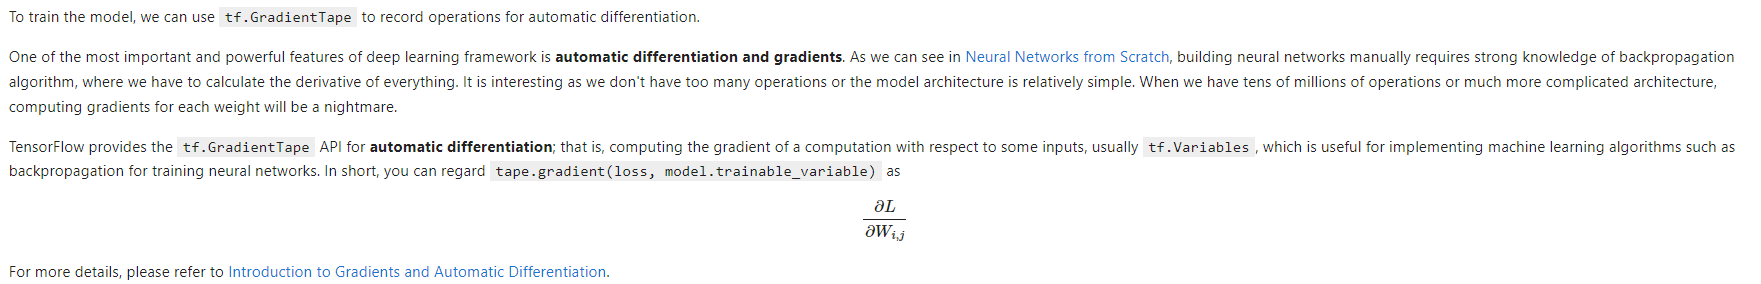

這段程式碼定義了一個用於執行訓練步驟的函數 `train_step`，這個函數使用了 TensorFlow 的 `@tf.function` 裝飾器，將其轉換為 TensorFlow 計算圖，以提高效能。

以下是這個訓練步驟的解釋：

- `@tf.function` 裝飾器：這會將函數 `train_step` 轉換為 TensorFlow 計算圖，從而加速執行。

- `with tf.GradientTape() as tape:`：建立一個梯度帶（GradientTape），用於記錄前向傳播中執行的操作，以便稍後計算梯度。

- `predictions = model(images, training=True)`：使用模型對輸入影像 `images` 進行前向傳播，並取得模型的預測結果。 `training=True` 表示在訓練模式下運行，這對於某些層（如 Dropout）可能有不同的行為。

- `loss = loss_object(labels, predictions)`：計算模型的預測值與真實標籤 `labels` 之間的損失。 `loss_object` 是先前定義的損失函數，通常是交叉熵損失。

- `gradients = tape.gradient(loss, model.trainable_variables)`：使用梯度帶計算損失相對於模型可訓練變數的梯度。 這些梯度將用於反向傳播和權重更新。

- `optimizer.apply_gradients(zip(gradients, model.trainable_variables))`：使用最佳化器來應用計算得到的梯度以更新模型的權重參數，從而最小化損失。

- `train_loss(loss)`：將損失值加到訓練損失指標 `train_loss` 中，用於追蹤訓練損失的平均值。

- `train_accuracy(labels, predictions)`：將標籤和模型的預測結果加入訓練準確率指標 `train_accuracy` 中，用於追蹤訓練準確率的表現。

這個函數實現了一個完整的訓練步驟，包括前向傳播、損失計算、梯度計算和權重更新。 它將用於循環迭代，以訓練神經網路模型。

In [27]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [28]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

Notice that the function decorated by tf.function will be compiled into a callable TensorFlow graph automatically. This allows the TensorFlow runtime to apply optimizations and exploit parallelism to boost computation performance. We will talk more about tf.function in the later section.

Let's train and evaluate the model first.

這段程式碼實現了一個循環，用於進行多個訓練週期（epochs）。 在每個訓練週期內，模型將在訓練資料集上進行訓練，然後在測試資料集上進行評估，同時記錄損失和準確率。 以下是這段程式碼的解釋：

- `EPOCHS = 5`：定義了要執行的訓練週期（epochs）的總數。

- `for epoch in range(EPOCHS):`：透過循環迭代每個訓練週期。

- 在每個訓練週期開始時，透過`train_loss.reset_states()`、`train_accuracy.reset_states()`、`test_loss.reset_states()` 和`test_accuracy.reset_states()` 來重置訓練和測試中的損失 和準確率指標。 這是為了在每個週期內重新開始記錄指標值。

- `for images, labels in train_ds:`：遍歷訓練資料集 (`train_ds`) 中的影像和標籤。

- `train_step(images, labels)`：呼叫先前定義的 `train_step` 函數，執行訓練步驟。

- `for test_images, test_labels in test_ds:`：遍歷測試資料集 (`test_ds`) 中的映像和標籤。

- `test_step(test_images, test_labels)`：呼叫類似 `train_step` 的測試步驟函數，對模型在測試資料上的效能進行評估。

- `template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f'`：定義了一個格式 字串，用於列印每個訓練週期的匯總資訊。

- `print (template.format(epoch+1, train_loss.result(), train_accuracy.result()*100, test_loss.result(), test_accuracy.result()*100))`：使用格式字串將每個 訓練週期的資訊會列印到螢幕上，包括訓練和測試的損失和準確率。

這個循環將遍歷多個訓練週期，執行訓練和測試，並在每個週期結束時輸出相應的效能指標，以便追蹤模型的訓練進度。

In [29]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           test_loss.result(),
                           test_accuracy.result()*100))

Epoch 1, Loss: 0.2994, Accuracy: 91.2333, Test Loss: 0.1398, Test Accuracy: 95.8300
Epoch 2, Loss: 0.1431, Accuracy: 95.7817, Test Loss: 0.1078, Test Accuracy: 96.8300
Epoch 3, Loss: 0.1074, Accuracy: 96.7417, Test Loss: 0.0884, Test Accuracy: 97.3200
Epoch 4, Loss: 0.0873, Accuracy: 97.2867, Test Loss: 0.0818, Test Accuracy: 97.5600
Epoch 5, Loss: 0.0754, Accuracy: 97.6350, Test Loss: 0.0737, Test Accuracy: 97.6300


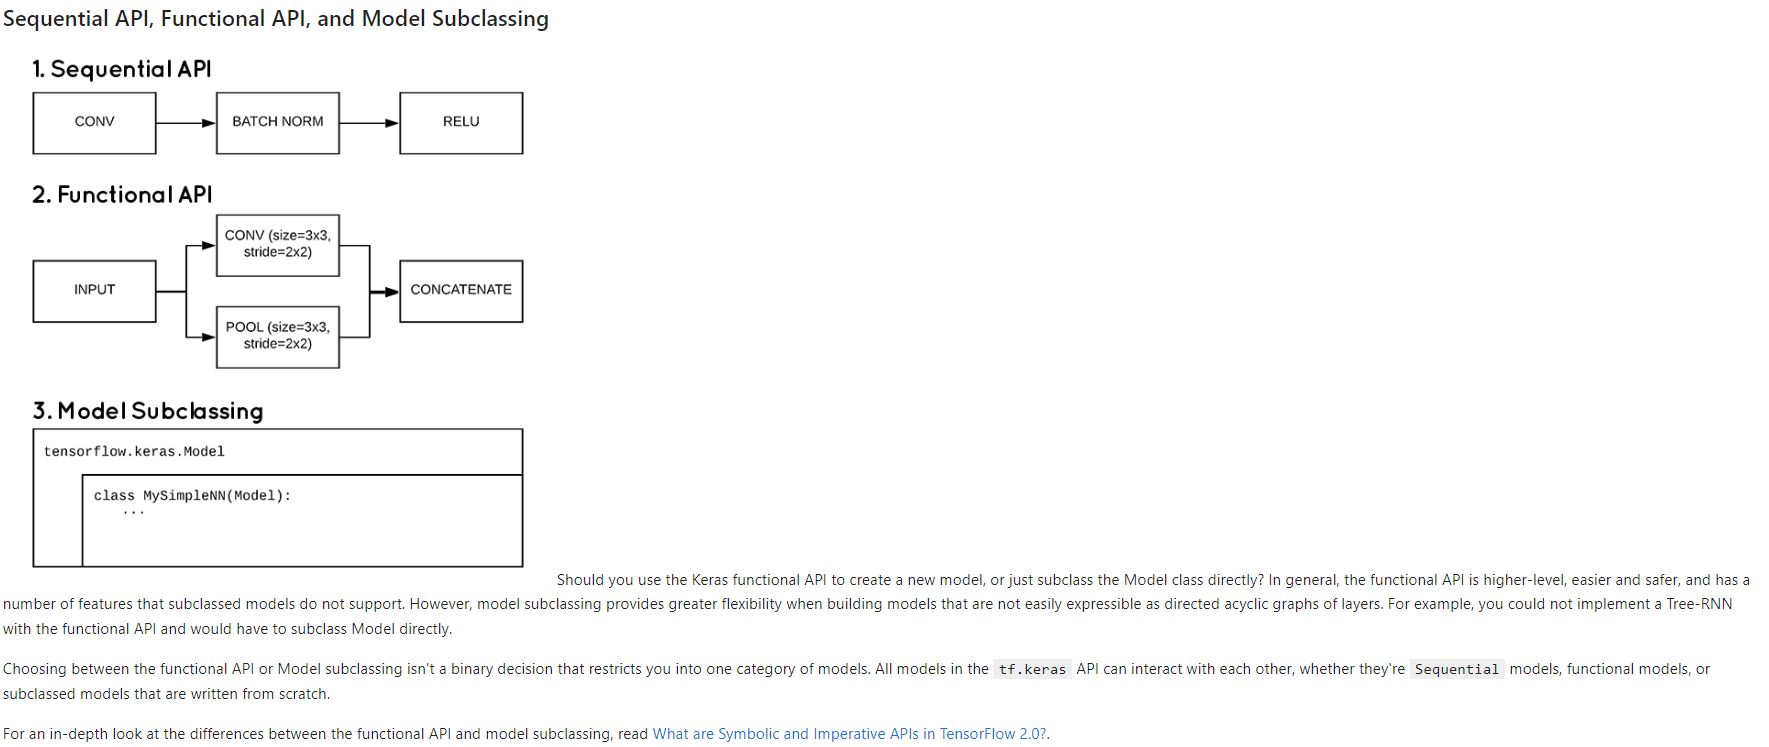

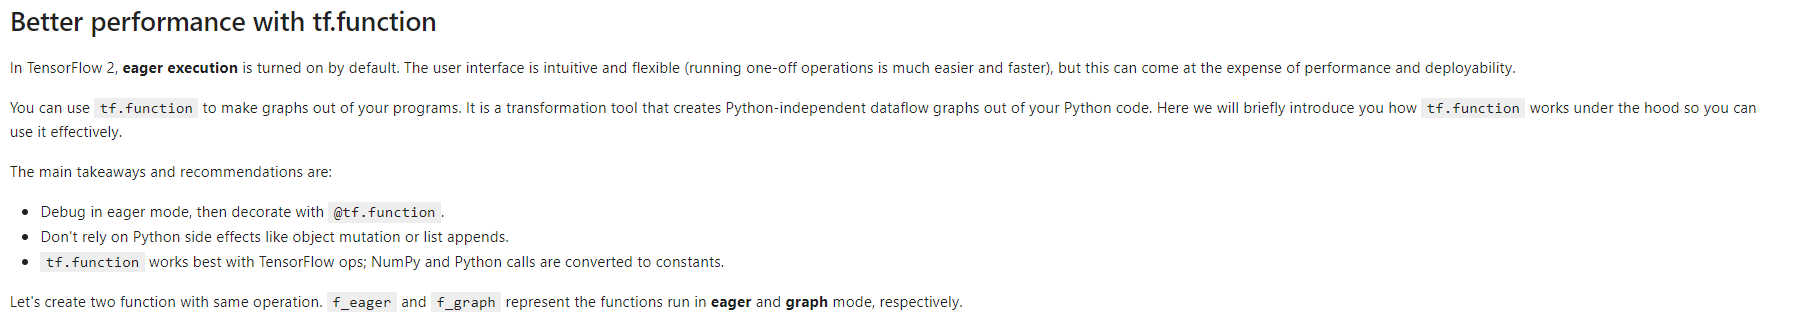

這段文字討論了使用 Keras 的不同方法來創建神經網路模型，即 Sequential API、Functional API 和 Model Subclassing，並提供了一些建議和效能優化的資訊。

1. **選擇建立模型的方式：** 在選擇使用 Keras 的哪種方式來建立模型時，需要考慮模型的複雜性和需求。 一般來說，Functional API 更進階、更容易使用，更安全，並且具有一些 Model Subclassing 不支援的特性。 然而，Model Subclassing 提供了更大的靈活性，特別適用於建構難以表達為層的有向無環圖的模型。 例如，使用 Functional API 無法實作 Tree-RNN，必須直接子類化 Model。

2. **選擇不是二元決策：** 選擇 Functional API 或 Model Subclassing 並不是將您限制在一個模型類別中的二元決策。 在 tf.keras API 中，所有模型都可以相互交互，無論它們是 Sequential 模型、Functional 模型還是從頭編寫的子類化模型。

3. **使用 tf.function 提高效能：** TensorFlow 2 中，預設開啟了即時執行（eager execution），這在使用者介面上更直觀和靈活，但可能以效能和部署性為代價。 您可以使用 `tf.function` 將程式轉換為圖，這是一種轉換工具，將您的 Python 程式碼轉換為獨立於 Python 的資料流程圖。 以下是一些關於 `tf.function` 的主要要點和建議：
    - 在即時執行模式下進行偵錯，然後使用 `@tf.function` 裝飾器。
    - 不依賴 Python 的副作用，如物件突變或列表附加。
    - `tf.function` 最適用於 TensorFlow 運算；NumPy 和 Python 呼叫會轉換為常數。
   
最後，文字提供了一個範例，建立了兩個函數 `f_eager` 和 `f_graph`，分別表示在即時執行模式和圖模式下運行的函數，以說明 `tf.function` 的工作原理。 這有助於提高 TensorFlow 模型的效能。

In [30]:
def f_eager(x, y):
    for i in tf.range(100000):
        _ = tf.reduce_mean(tf.multiply(x ** 2, 3) + y)
    return tf.reduce_mean(tf.multiply(x ** 2, 3) + y)

@tf.function
def f_graph(x, y):
    for i in tf.range(100000):
        _ = tf.reduce_mean(tf.multiply(x ** 2, 3) + y)
    return tf.reduce_mean(tf.multiply(x ** 2, 3) + y)

In [31]:
x = tf.constant([[2.0, 3.0]])
y = tf.constant([[3.0, -2.0]])

In [32]:
# `f_eager` and `f_graph` return same values, but `f_graph` is executed as a TensorFlow graph.
assert f_eager(x, y).numpy() == f_graph(x, y).numpy()

In [33]:
%time _ = f_eager(x, y)

CPU times: user 43.9 s, sys: 90.6 ms, total: 44 s
Wall time: 44 s


In [34]:
%time _ = f_graph(x, y)

CPU times: user 802 µs, sys: 17 µs, total: 819 µs
Wall time: 626 µs


As you can see, functions decorated with @tf.function can be faster than eager code, especially for graphs with many small ops. But for graphs with a few expensive ops (like convolutions), you may not see much speedup.

If your code uses multiple functions, you don't need to annotate them all - any functions called from an annotated function will also run in graph mode. Therefore, you only need to decorate the outermost function only.

如文本中所提到的，使用 `@tf.function` 裝飾的函數可能比即時執行模式的程式碼更快，特別是對於包含許多小操作的圖形。 但對於包含少量昂貴操作（例如捲積）的圖形，可能不會看到太大的加速效果。

如果您的程式碼使用多個函數，您不需要為它們全部添加裝飾符 - 從裝飾的函數呼叫的任何函數也將在圖模式下運行。 因此，您只需要為最外層函數新增裝飾符，內部呼叫的函數就會自動以圖模式執行。 這提供了更靈活的方式來利用 `tf.function` 來提高效能，而不需要為每個函數手動添加裝飾符。

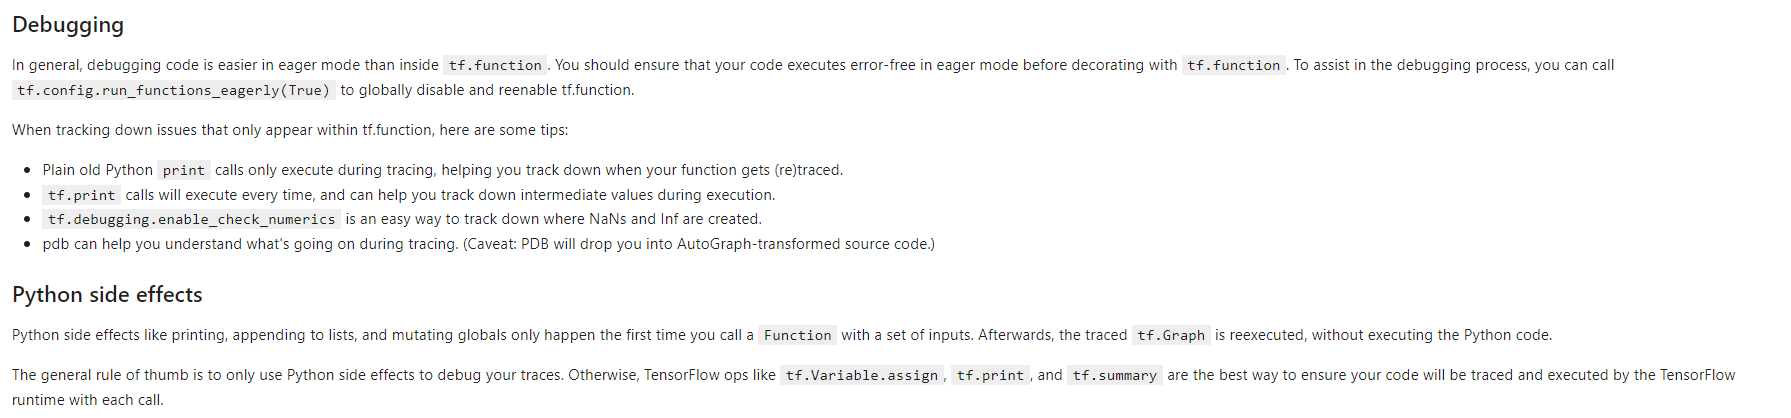

在一般情況下，使用即時執行模式進行程式碼偵錯要比在 `tf.function` 內部容易。 在將程式碼裝飾為 `tf.function` 之前，您應確保程式碼在即時執行模式下無誤地執行。 為了協助偵錯過程，您可以呼叫 `tf.config.run_functions_eagerly(True)` 全域停用和重新啟用 `tf.function`。

當追蹤僅在 `tf.function` 中出現的問題時，以下是一些建議：

- 普通的 Python 列印語句只在追蹤時執行，有助於追蹤您的函數何時被（重新）追蹤。

- `tf.print` 呼叫會在每次執行時執行，並可協助您追蹤執行過程中的中間值。

- `tf.debugging.enable_check_numerics` 是追蹤 NaN 和 Inf 產生位置的簡單方法。

- `pdb` 可以幫助您在追蹤過程中了解發生了什麼。 請注意：PDB 將帶您進入 AutoGraph 轉換的源代碼中。

Python 副作用
Python 副作用，如列印、附加到列表和更改全域變量，僅在第一次呼叫具有一組輸入的函數時發生。 之後，已追蹤的 `tf.Graph` 會被重新執行，而不會執行 Python 程式碼。

一般的經驗法則是只使用 Python 副作用來調試您的追蹤。 否則，TensorFlow 操作，例如 `tf.Variable.assign`、`tf.print` 和 `tf.summary`，是確保您的程式碼將在每次呼叫時由 TensorFlow 執行時間追蹤和執行的最佳方式。 這有助於確保 TensorFlow 運行時能如預期執行您的程式碼。

In [35]:
# 在 graph mode要用tf.print()
@tf.function
def f(x):
    print("Traced with", x)
    tf.print("Executed with", x)

In [36]:
f(1)
f(1)
f(2)

Traced with 1
Executed with 1
Executed with 1
Traced with 2
Executed with 2


As we can see, `print` function works unexpectedly, while `tf.print` calls execute every time. Another gotcha we can see below is mutating globals.

In [37]:
g = 0

@tf.function
def mutate_globals(x):
    return x + g

# tf.function captures the value of the global during the first run
print("First call: ", mutate_globals(tf.constant(1)))
g = 10  # Update the global

# Subsequent runs may silently use the cached value of the globals
print("Second call: ", mutate_globals(tf.constant(2)))

# tf.function re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print("Third call, different type: ", mutate_globals(tf.constant([4.])))

First call:  tf.Tensor(1, shape=(), dtype=int32)
Second call:  tf.Tensor(2, shape=(), dtype=int32)
Third call, different type:  tf.Tensor([14.], shape=(1,), dtype=float32)


In addition, many Python features, such as generators and iterators, rely on the Python runtime to keep track of state. In general, while these constructs work as expected in eager mode, many unexpected things can happen inside a `Function`.

For more details about `tf.function` and `Autograph`, including how conditionals and loops work and how to trace code and debug inside `tf.function`, please refer to tutorial and video.

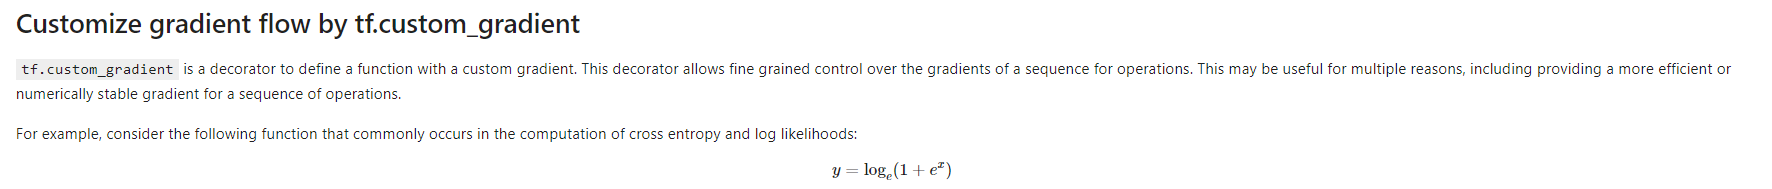

`tf.custom_gradient` 是一個裝飾器，用於定義具有自訂梯度的函數。 這個裝飾器允許對操作序列的梯度進行精細控制。 這對多種原因可能很有用，包括為一系列操作提供更有效率或數值穩定的梯度。

舉例來說，考慮下面的函數，它在計算交叉熵和對數似然時常常出現：
y = log(1 + e^x)

這個函數中包含了指數運算和對數運算，使用 `tf.custom_gradient` 裝飾器可以定義一個自訂的梯度函數，以更有效地計算梯度。 這對於提高數值穩定性和計算效率非常有用，特別是在深度學習中的損失函數計算中經常會遇到。 透過自訂梯度函數，您可以更好地控制和優化反向傳播的過程。

In [38]:
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))

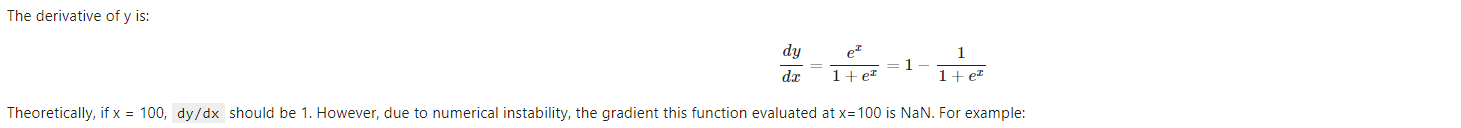

這段程式碼使用 TensorFlow 來計算函數 y = log(1 + e^x) 相對於 x 的梯度。 但是，由於這個函數的梯度可能包含數值上不穩定的情況，導致計算結果為 NaN（不是一個數字）。

在程式碼中的 `g.watch(x)` 用來告訴 TensorFlow 要監視變數 `x`，以便計算相對於它的梯度。

然後，使用 `g.gradient(y, x)` 來計算函數 `y` 相對於 `x` 的梯度。 然而，由於函數中涉及指數運算和對數運算，梯度計算可能會出現數值不穩定性，導致梯度值為 NaN。

最後，將梯度值列印出來，即 `dy`，但由於存在 NaN 值，列印結果可能為 NaN。

這種情況通常需要特殊的數值穩定性技巧來處理，以確保在計算梯度時不會出現 NaN。 例如，可以使用軟體加法（softplus）函數或其他數值穩定的方法來重新定義函數以避免梯度問題。

In [39]:
x = tf.constant(100.)
with tf.GradientTape() as g:
    g.watch(x)
    y = log1pexp(x)
dy = g.gradient(y, x) # Will be evaluated as NaN
print("dy/dx =", dy.numpy())

dy/dx = nan


The gradient expression can be analytically simplified to provide numerical stability:

这个自定义的梯度函数会计算输入 x 的梯度，并在其中应用了数值稳定的技巧，以确保梯度的稳定性。

接下来，计算 log1pexp(x) 相对于 x 的梯度，将结果存储在 dy 中。由于自定义梯度的应用，这次计算的结果将为 1.0，而不会出现 NaN。

最后，将梯度值打印出来，即 dy，结果应该是 1.0。这个自定义梯度函数帮助解决了数值不稳定性问题，使梯度计算更加可靠。

In [40]:
@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.math.log(1 + e), grad

In [41]:
x = tf.constant(100.)
with tf.GradientTape() as g:
    g.watch(x)
    y = log1pexp(x)
dy = g.gradient(y, x) # Will be evaluated as 1.0
print("dy/dx =", dy.numpy())

dy/dx = 1.0
